/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


total param is 4621442


Some weights of ProtT5PrefixForSequenceClassification were not initialized from the model checkpoint at Rostlab/prot_t5_xl_uniref50 and are newly initialized: ['classifier.mlp1.bias', 'classifier.mlp1.weight', 'classifier.mlp2.bias', 'classifier.mlp2.weight', 'classifier.mlp3.bias', 'classifier.mlp3.weight', 'classifier.mlp4.bias', 'classifier.mlp4.weight', 'prefix_encoder.embedding.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


classifier.mlp1.weight 524288
classifier.mlp1.bias 512
classifier.mlp2.weight 131072
classifier.mlp2.bias 256
classifier.mlp3.weight 32768
classifier.mlp3.bias 128
classifier.mlp4.weight 256
classifier.mlp4.bias 2
prefix_encoder.embedding.weight 3932160
centers 2048
total parameters: 4623490
epoch1:, loss:16.3695,val_loss2.9101,train_acc0.7774,val_acc0.7852,test_acc0.7712
epoch2:, loss:2.8706,val_loss2.8841,train_acc0.8030,val_acc0.8043,test_acc0.8130
epoch3:, loss:2.8545,val_loss2.8235,train_acc0.8488,val_acc0.8437,test_acc0.8596
epoch4:, loss:2.7729,val_loss2.7276,train_acc0.8589,val_acc0.8473,test_acc0.8590
epoch5:, loss:2.7141,val_loss2.6291,train_acc0.9042,val_acc0.8735,test_acc0.8871
epoch6:, loss:2.6175,val_loss2.5681,train_acc0.9208,val_acc0.8878,test_acc0.8949
epoch7:, loss:2.5456,val_loss2.6367,train_acc0.9357,val_acc0.9093,test_acc0.9074
epoch8:, loss:2.4500,val_loss2.4814,train_acc0.9470,val_acc0.9021,test_acc0.9176
epoch9:, loss:2.4813,val_loss2.5509,train_acc0.9363,val_ac

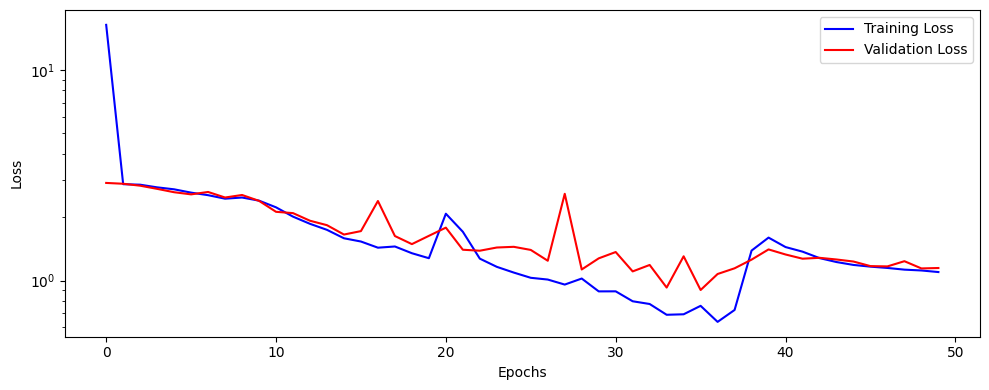

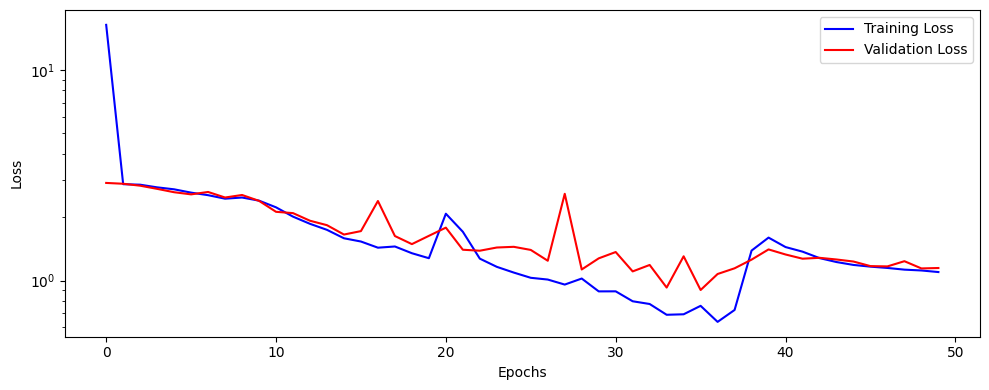

In [3]:
from new_model import ProtT5PrefixForSequenceClassification
from dataset import PlantAMPDataset,LabelBalancedBatchSampler
from StepByStepForTraining import StepByStepForTraining
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import AutoConfig,T5Tokenizer
from LossFunction import TripletLoss,TripletCenterLoss
from torch.optim.lr_scheduler import StepLR, CyclicLR, LambdaLR

# torch.backends.cudnn.enable =True
# torch.backends.cudnn.benchmark = True

# set the epochs、batch size and learning rate
n_epoch = 50
batch_size = 8
learning_rate =1.25E-02

pretrained_path="Rostlab/prot_t5_xl_uniref50"
# loaded_path = "../saved_model/Margin8.0_Contrasive_ProtT5_Prompt20_acc:0.9367"
tokenizer=T5Tokenizer.from_pretrained(pretrained_path, do_lower_case=False )

#set the hyperparameters
config = AutoConfig.from_pretrained(pretrained_path)
config.pre_seq_len=20
config.prefix_projection=False
config.num_labels=2
config.classifier_dropout=0.1
config.margin = 8.0
# config.margin = 5.0
config.lam=1.0
#learning rate of TCL
config.tcl_lr = 0.01

# config = AutoConfig.from_pretrained(loaded_path)

#data preparation
train_path='../dataset/plant_train.csv'
train_dataset=PlantAMPDataset(train_path,tokenizer=tokenizer)
val_path='../dataset/plant_val.csv'
val_dataset=PlantAMPDataset(val_path,tokenizer=tokenizer)
test_path="../dataset/plant_test.csv"
test_dataset=PlantAMPDataset(test_path,tokenizer=tokenizer)
# train_loader = torch.utils.data.DataLoader(
#                           train_dataset,
#                           batch_size=batch_size, num_workers=2,shuffle=True)
train_loader = torch.utils.data.DataLoader(
                          train_dataset,
                          batch_sampler=LabelBalancedBatchSampler(train_dataset, batch_size))
val_loader = torch.utils.data.DataLoader(
                          val_dataset,
                          batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(
                          test_dataset,
                          batch_size=batch_size)

#initialize parameters of m
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        # nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
            
#model configuration
model = ProtT5PrefixForSequenceClassification.from_pretrained(pretrained_path,config=config)
# model = ProtT5PrefixForSequenceClassification.from_pretrained(loaded_path)

with torch.no_grad():
    model.classifier.apply(weights_init)

# for param in model.prefix_encoder.parameters():
#     param.requires_grad = False


# for param in model.classifier.parameters():
#     # param.requires_grad = False
#     param.requires_grad = True


all_param=0
for name, param in model.named_parameters():
    if param.requires_grad == True:
        all_param += param.numel()
        print(name,param.numel())
# print("total parameters:",all_param)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# loss = nn.CrossEntropyLoss(reduction='sum')
loss = nn.CrossEntropyLoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate,betas=(0.9, 0.999), eps=1e-8,weight_decay=1e-04)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)
#epoch learning rate scheduler,#step_size for epoch
# step_scheduler = StepLR(optimizer, step_size=20, gamma=0.5)
#step learning rate scheduler,step_size for min_batch,max_lr is been test on LR_Test
# # cyclic_scheduler = CyclicLR(optimizer, base_lr=1.0E-06, max_lr=1.5E-03,  step_size_up=len(train_loader)*3, mode='triangular2')



#set triplelet_loss
# triplelet_loss = TripletLoss(margin=config.margin)
triplelet_center_loss = TripletCenterLoss(margin=config.margin)
tcl_lr = config.tcl_lr
# tcl_optimizer = torch.optim.AdamW(triplelet_center_loss.parameters(), lr=tcl_lr, betas=(0.9, 0.999), eps=1e-8,weight_decay=1e-04)
tcl_optimizer = torch.optim.SGD(triplelet_center_loss.parameters(), lr=tcl_lr)
for name, param in triplelet_center_loss.named_parameters():
    if param.requires_grad == True:
        all_param += param.numel()
        print(name,param.numel())
print("total parameters:",all_param)


#construct trainer
sbs_contrasive = StepByStepForTraining(model, loss, optimizer)

#set accumulate step
# sbs_contrasive.set_accelerater(gradient_accumulation_steps=8)
sbs_contrasive.set_accelerater(gradient_accumulation_steps=4)

sbs_contrasive.set_tcl_optimizer(tcl_optimizer)
# sbs_contrasive.set_lr_scheduler(cyclic_scheduler)
# sbs_contrasive.set_lr_scheduler(step_scheduler)

# sbs_contrasive.set_tripletloss(triplelet_loss)
sbs_contrasive.set_tripletloss(triplelet_center_loss)

# track,fig=sbs_contrasive.lr_range_test(train_loader, 0.1, num_iter=100, step_mode='exp', alpha=0.05)
# fig.plot()


#train for the classifier(without contrastive)
# sbs_contrasive.train_classifier(n_epoch,best_acc=0.9150)

#train for the feature extractor for triple loss
# sbs_contrasive.train_accelerate_triplelet(n_epoch)


#train loss have both of CrossEntropy and tripleletloss,train for the whole model，best_acc is initial best acc
# sbs_contrasive.train_accelerate_combined(n_epoch,best_acc=0.9367)
sbs_contrasive.train_accelerate_combined(n_epoch,best_acc=0.9200)

sbs_contrasive.plot_losses()

# results=NewStepByStepForContrasive.loader_apply(sbs_contrasive.val_loader, sbs_contrasive.correct)
# val_result=torch.sum(results,dim=0)
# val_acc = val_result[0] / val_result[1]
# print(f"val_accuracy:{val_acc}")
# filename=f"../saved_model/ProtT5_Prompt_checkpoint_loss{sbs_seq.val_losses[-1]}_acc{val_acc}.pth"
# sbs_seq.save_checkpoint(filename)


In [10]:
checkpoint = {'epoch': sbs_contrasive.total_epochs,
                      # 'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': sbs_contrasive.optimizer.state_dict(),
                      "tcl_optimizer_state_dict":sbs_contrasive.tcl_optimizer.state_dict(),
                      'loss': sbs_contrasive.losses,
                      'val_loss': sbs_contrasive.val_losses,
                      "TCL_loss":sbs_contrasive.triple_loss_fn.state_dict()
                     }
filename="../saved_model/Margin8.0_Contrasive_ProtT5_Prompt20_lambda0.3/checkpoint.pth"
torch.save(checkpoint, filename)

In [4]:
print(config.lam)

0.3


In [4]:
# sbs_contrasive.train_accelerate_triplelet(n_epoch)
sbs_contrasive.train_accelerate_combined(20,best_acc=0.9368)

epoch1:, loss:0.2903,val_loss1.5308,train_acc0.9869,val_acc0.9165,test_acc0.9319
epoch2:, loss:0.2772,val_loss1.4098,train_acc0.9875,val_acc0.9260,test_acc0.9301
epoch3:, loss:0.2831,val_loss1.4340,train_acc0.9827,val_acc0.9224,test_acc0.9247
epoch4:, saved val_acc 0.9391 test_acc:0.9319
loss:0.2581,val_loss1.3523,train_acc0.9887,val_acc0.9391,test_acc0.9319
epoch5:, loss:0.2248,val_loss1.3225,train_acc0.9887,val_acc0.9320,test_acc0.9277
epoch6:, loss:0.2406,val_loss1.2683,train_acc0.9881,val_acc0.9368,test_acc0.9277
epoch7:, loss:0.2100,val_loss1.4327,train_acc0.9887,val_acc0.9272,test_acc0.9253
epoch8:, loss:0.2125,val_loss1.3127,train_acc0.9881,val_acc0.9296,test_acc0.9259
epoch9:, loss:0.2118,val_loss1.9772,train_acc0.9887,val_acc0.9177,test_acc0.9229
epoch10:, loss:0.2323,val_loss1.1992,train_acc0.9905,val_acc0.9356,test_acc0.9301
epoch11:, loss:0.2023,val_loss1.3118,train_acc0.9899,val_acc0.9344,test_acc0.9301
epoch12:, loss:0.1803,val_loss1.7785,train_acc0.9893,val_acc0.9284,tes

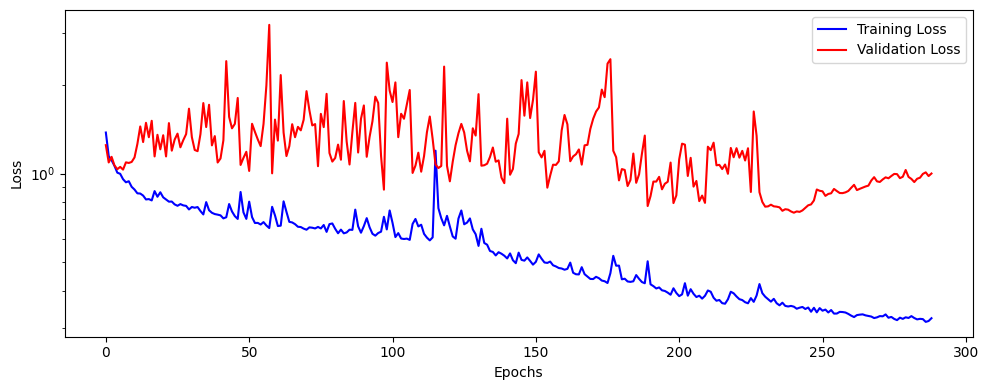

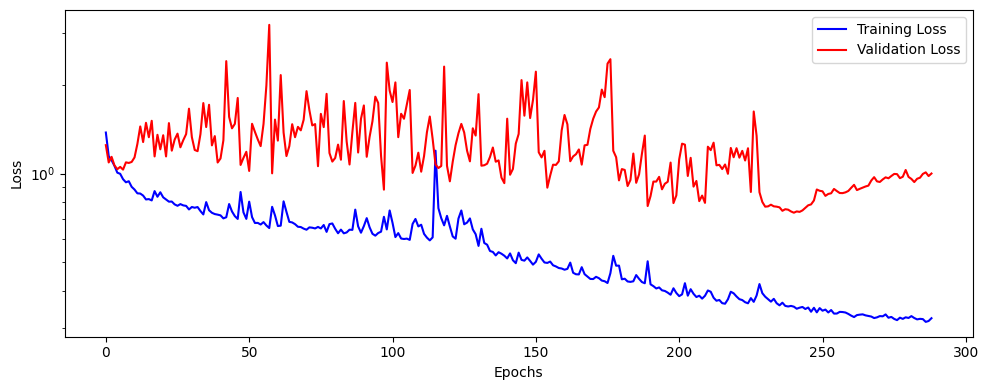

In [9]:
sbs_contrasive.plot_losses()